# Step 2. Apply the model for prediction
## step 2.1 Load the packages.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import joblib
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# extra functions
from utility import vec2mat, mean_absolute_error, mean_absolute_percentage_error, plot_result, report_results


##  Step 2.2 Load the pre-trained model

In [2]:
filename = './models/MLP.demand.TF' + '.hdf5'
model = tf.keras.models.load_model(filename)
model.summary() # check the information

Model: "MLP_Demand_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer (Dense)         (None, 100)               1300      
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 101       
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


## Step 2.3 Prepare the data for test

### read all the test csv files

In [3]:
path = Path("../Data/raw/AEMO/test/")
all_files = glob.glob(os.path.join(path, "*.csv"))
df_csv = pd.concat((pd.read_csv(f) for f in all_files))
# df_csv.describe(include = 'all')
df_csv.describe()

,TOTALDEMAND,RRP
count,7008.000000,7008.000000
mean,4685.549846,62.707730
std,783.134633,462.396756
min,3060.580000,-304.150000
25%,4117.512500,33.360000
50%,4586.710000,43.010000
75%,5118.200000,54.342500
max,9507.260000,14700.000000


### take a look of the demand data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2c8217d50>],
      dtype=object)

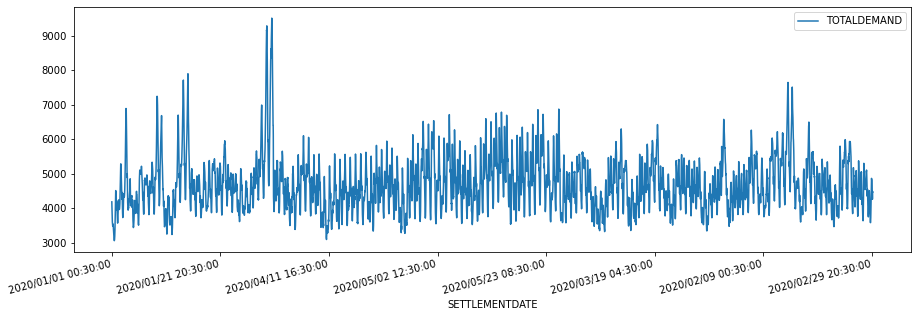

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt 
df_csv.plot(x="SETTLEMENTDATE", y=["TOTALDEMAND"], figsize=(15,5), rot = 15, subplots=True)

### load the scaler function of the demand from our training phase.

**Notice Important**

Remember unitl now, we have no idea of any statistic feature of the test data, the scaler function must be the same one from the training data set.

If you build a new scaler function on the test data set, the officail name of this is called: `Data Snooping`:

Data snooping is the most common trap for practitioners in learning from the data. 
The principle involved is simple enough.
If a data set has affected any step in the learning process, its ability to assess the outcome has been compromised.
As the saying goes, if you torture the data long enough, it will confess.

In [5]:
filename = './models/scaler_demand.joblib' + '.z'
scaler_demand = joblib.load(filename)

### generate the test sample paris.

In [6]:
def generate_test_data(df_csv, n_dim_in, n_dim_out, scalar):
    data_demand = df_csv["TOTALDEMAND"].to_numpy().reshape(-1, 1) # extract the column
    X_demand = scalar.transform(data_demand) # normalise the values with statistic we learned from training data
    M_demand = vec2mat(X_demand, n_dim_in, n_dim_out)
    n_row, n_col = M_demand.shape
    X = M_demand[:, 0:n_col-n_dim_out]
    y = M_demand[:, n_col-n_dim_out:]
    return X, y

# get the input and ouput shape from our model
n_dim_in = model.input_shape[1]
n_dim_out = model.output_shape[1]

# the salar function is from our training dataset.
X_test, y_test = generate_test_data(df_csv, n_dim_in, n_dim_out, scalar = scaler_demand)

print(f'Test samples: input {X_test.shape}, target {y_test.shape}')

Test samples: input (6996, 12), target (6996, 1)


# Step 2.4 Apply the pre-trained model on test data

In [7]:
print("# Test results:")
y_pred = model.predict(X_test) 
mae  , mape  = report_results(y_test, y_pred, scaler = scaler_demand)
print("[MAE ]: %.4f"     % mae)
print("[MAPE]: %.4f %% " % mape)

# Test results:
[MAE ]: 59.3224
[MAPE]: 1.2649 % 


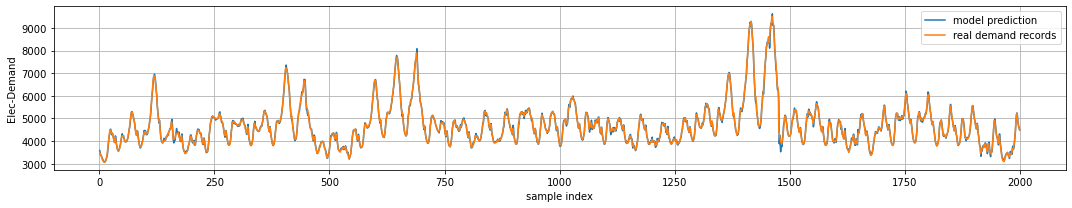

In [8]:
plot_result(y_pred, y_test, scaler = scaler_demand, length=2000) # check the first 2000 samples.

## Step 2.5 Save model's prediction to CSV files.

In [9]:
# Get real prediction of the demand
totaldemand_prediction = scaler_demand.inverse_transform(y_pred)

In [10]:
 df_csv.head(5)

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,VIC1,2020/01/01 00:30:00,4185.32,64.76,TRADE
1,VIC1,2020/01/01 01:00:00,4057.68,63.36,TRADE
2,VIC1,2020/01/01 01:30:00,3954.85,65.21,TRADE
3,VIC1,2020/01/01 02:00:00,3792.25,64.45,TRADE
4,VIC1,2020/01/01 02:30:00,3689.33,63.23,TRADE


In [11]:
empty = np.full((n_dim_in,1), np.nan) # no prediction of the first few rows.
df_csv.insert(3, 'Demand_Prediction_MLP',  np.concatenate((empty, totaldemand_prediction), axis=0)  ) 

In [12]:
 df_csv.head(20)

,REGION,SETTLEMENTDATE,TOTALDEMAND,Demand_Prediction_MLP,RRP,PERIODTYPE
0,VIC1,2020/01/01 00:30:00,4185.32,NaN,64.76,TRADE
1,VIC1,2020/01/01 01:00:00,4057.68,NaN,63.36,TRADE
2,VIC1,2020/01/01 01:30:00,3954.85,NaN,65.21,TRADE
3,VIC1,2020/01/01 02:00:00,3792.25,NaN,64.45,TRADE
4,VIC1,2020/01/01 02:30:00,3689.33,NaN,63.23,TRADE
5,VIC1,2020/01/01 03:00:00,3602.61,NaN,61.91,TRADE
6,VIC1,2020/01/01 03:30:00,3550.62,NaN,61.18,TRADE
7,VIC1,2020/01/01 04:00:00,3504.19,NaN,58.32,TRADE
8,VIC1,2020/01/01 04:30:00,3491.36,NaN,53.75,TRADE
9,VIC1,2020/01/01 05:00:00,3483.63,NaN,51.03,TRADE


In [13]:
df_csv.describe()

,TOTALDEMAND,Demand_Prediction_MLP,RRP
count,7008.000000,6996.000000,7008.000000
mean,4685.549846,4688.987625,62.707730
std,783.134633,782.122144,462.396756
min,3060.580000,3077.665527,-304.150000
25%,4117.512500,4120.112671,33.360000
50%,4586.710000,4588.725098,43.010000
75%,5118.200000,5115.574463,54.342500
max,9507.260000,9625.074219,14700.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2c9a98f90>,
      dtype=object)

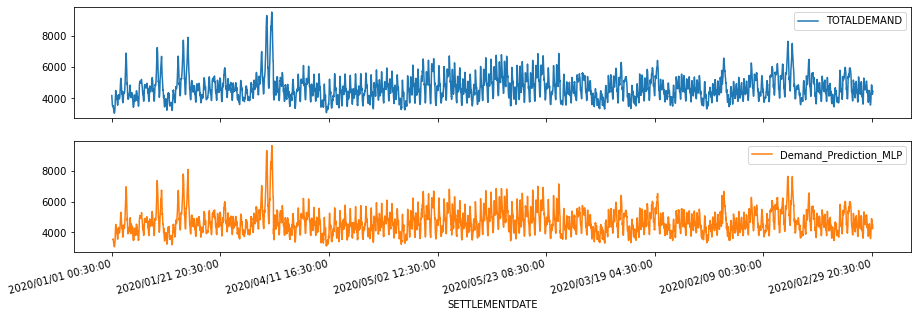

In [14]:
df_csv.plot(x="SETTLEMENTDATE", y=["TOTALDEMAND", "Demand_Prediction_MLP"], figsize=(15,5), rot = 15, subplots=True)

In [15]:
filename = '2020_Jan_to_May_elec_demand_prediction.csv'
df_csv.to_csv(filename, index=False)

### THE EMD